In [1]:
import numpy as np
import pandas as pd
import bloscpack as bp

import matplotlib.pyplot as plt

import imgaug as ia
import imgaug.augmenters as iaa

In [2]:
import fastai
from fastai.vision import *

from optim import Over9000

In [2]:
from torch.utils.data.dataloader import DataLoader
from data import DS_TRN

In [2]:
from model import *
from model_utils import *

---

In [5]:
SEED = 20190819

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [3]:
trn_imgs = bp.unpack_ndarray_from_file('../features/train_images.bloscpack')
# see preprocess notebook, it's shown that the train.csv data sequence is the same and can just load like this.
trn_lbls = pd.read_csv('../input/train.csv').iloc[:, 1:4].values

In [77]:
augs = iaa.SomeOf(
    (0, 3),
    [
        iaa.OneOf(
            [
                iaa.Affine(scale={"x": (0.8, 1.1), "y": (0.8, 1.1)}, rotate=(-20, 20), shear=(-20, 20)),
                iaa.PiecewiseAffine(scale=(0.02, 0.03)),
                iaa.PerspectiveTransform(scale=.1, keep_size=True),
            ]
        ),
        iaa.OneOf(
            [
                iaa.GaussianBlur(sigma=(1., 3.)),
#                 iaa.MotionBlur(k=(7, 13), angle=[-45, 45]),
                iaa.MedianBlur(k=(3, 7)),
            ]
        ),
        iaa.OneOf(
            [
                iaa.DirectedEdgeDetect(alpha=(.5, 1.0), direction=(0.0, 1.0)),
                iaa.Emboss(alpha=(.1, 1.), strength=(.5, 1.5)),
            ]
        ),
#         iaa.CoarseDropout((0.05, 0.15), size_percent=(0.15, 0.35)),
#         iaa.Fog(),
    ],
    random_order=True
)

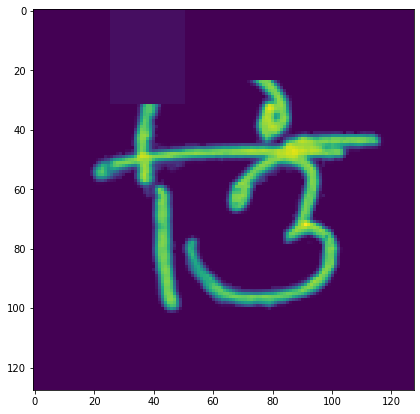

In [379]:
# augs = iaa.Emboss(alpha=(.1, 1.), strength=(.5, 1.5))
# augs = iaa.DirectedEdgeDetect(alpha=(.5, 1.0), direction=(0.0, 1.0))
# augs = iaa.Affine(scale={"x": (0.8, 1.15), "y": (0.8, 1.15)}, rotate=(-20, 20), shear=(-20, 20))
augs = iaa.RelativeRegularGridVoronoi((0.03, 0.05), (0.03, 0.05), p_drop_points=(0.02, .05), p_replace=(.02, .05), max_size=512)
img_arr = training_set[100][0][0]
# img_arr = np.stack([img_arr, img_arr, img_arr], -1)
# img_arr = img_arr[np.newaxis, :]
plt.figure(figsize=(7, 7))
plt.imshow(augs(image=img_arr))

In [5]:
training_set = DS_TRN(trn_imgs[:160000, np.newaxis], trn_lbls[:160000], transform=None, norm=False)
# validation_set = DS_TRN(trn_imgs[160000:, np.newaxis], trn_lbls[160000:])

# training_loader = DataLoader(training_set, batch_size=64, shuffle=True, num_workers=4)
# validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=4)

# dat_bunch = DataBunch(train_dl=training_loader, valid_dl=validation_loader)

---
### model

In [9]:
device = 'cuda:0'
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

In [10]:
predictor = PretrainedCNN(out_dim=n_total)
classifier = BengaliClassifier(predictor)#.to(device)

In [11]:
learn = Learner(
    dat_bunch,
    classifier,
    loss_func=Loss_combine(),
    opt_func=Over9000,
    metrics=[Metric_grapheme(), Metric_vowel(), Metric_consonant(),Metric_tot()]
)

logger = CSVLogger(learn, 'Seresnext_DensenetStarterSetup_Myaugs')

learn.clip_grad = 1.0
learn.split([classifier.predictor.lin_layers])
# learn.split([classifier.head1])
learn.unfreeze()

In [12]:
learn.fit_one_cycle(
    32,
    max_lr=slice(0.2e-2,1e-2),
    wd=[1e-3, 0.1e-1],
    pct_start=0.0,
    div_factor=100,
    callbacks=[logger, SaveModelCallback(learn,monitor='metric_tot', mode='max', name='Seresnext_DensenetStarterSetup_Myaugs'), MixUpCallback(learn)]
)

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.429123,0.411018,0.849430,0.943026,0.894503,0.884097,39:29


KeyboardInterrupt: 